In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorspacious as cs
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from plotly.graph_objs import Layout
from PIL import Image
from skimage.color import lab2rgb

from utils import *

In [4]:
beta = excel_to_dataframe("data/patch_spectra.xlsx")
L_i = excel_to_dataframe("data/light_spectra.xlsx")
CMF = excel_to_dataframe("data/CMF_xyz_2deg.xlsx")
df_colors = excel_to_dataframe("data/RGB.xlsx")

x = CMF.iloc[:, 1]
y = CMF.iloc[:, 2]
z = CMF.iloc[:, 3]
x = CMF.iloc[:, 1].values
y = CMF.iloc[:, 2].values
z = CMF.iloc[:, 3].values

# Invert beta's lines and columns (lines : wavelengths, columns : patches)
beta = beta.T

# For L_i and beta, ignore one line out of 5, to work with CMF
L_i = L_i.iloc[::5, :]
beta = beta.iloc[1::5, :]

# Drop the first row and set the index to the first column
L_i.index = L_i.iloc[:, 0]
L_i = L_i.iloc[:, 1:]

# Retrieve the indexes of either L_i or beta to create a wavelength vector for accessions
wavelengths = L_i.index
num_illuminants = L_i.shape[1]
num_patches = beta.shape[1]

illuminant_names = L_i.columns.tolist()

print("L_i (light spectra) : ", L_i.shape)
print("Beta (patch spectra) : ", beta.shape)
print("CMF : ", CMF.shape)
print("x : ", x.shape)
print("y : ", y.shape)
print("z : ", z.shape)
print("Wavelengths : ", wavelengths.shape)


L_i (light spectra) :  (81, 19)
Beta (patch spectra) :  (81, 189)
CMF :  (81, 4)
x :  (81,)
y :  (81,)
z :  (81,)
Wavelengths :  (81,)


In [5]:
# 1. Create the X, Y, Z values for each illuminant
X_w = []
Y_w = []
Z_w = []

for i in range(num_illuminants):
    k = 100 / np.sum(L_i.iloc[:, i] * y)
    X_w.append(k * np.sum(L_i.iloc[:, i] * x))
    Y_w.append(k * np.sum(L_i.iloc[:, i] * y))
    Z_w.append(k * np.sum(L_i.iloc[:, i] * z))

# Create a matrix to store the X, Y, Z values for each illuminant
XYZ_w = np.zeros((num_illuminants, 3))
XYZ_w[:, 0] = X_w
XYZ_w[:, 1] = Y_w
XYZ_w[:, 2] = Z_w

print("XYZ_w : ", XYZ_w.shape)
print(XYZ_w)

XYZ_w :  (19, 3)
[[1.60154370e+02 1.00000000e+02 1.00612356e+03]
 [7.13063428e+01 1.00000000e+02 4.99987258e+02]
 [1.51240925e+01 1.00000000e+02 8.03871027e+01]
 [2.64869448e+02 1.00000000e+02 1.23778967e+00]
 [2.59717616e+02 1.00000000e+02 4.93558626e+00]
 [2.47341635e+02 1.00000000e+02 8.90397434e+00]
 [1.52280989e+02 1.00000000e+02 3.47135057e+01]
 [1.40417408e+02 1.00000000e+02 3.94129370e+01]
 [1.96394455e+01 1.00000000e+02 2.01657114e+01]
 [2.88005575e+01 1.00000000e+02 9.40863650e+00]
 [7.49545217e+01 1.00000000e+02 6.27720488e+00]
 [2.08714366e+02 1.00000000e+02 1.50598494e-01]
 [1.33848775e+02 1.00000000e+02 1.25166479e+00]
 [2.31052051e+02 1.00000000e+02 1.63651778e-01]
 [2.52003395e+02 1.00000000e+02 2.51939716e-01]
 [1.02486469e+03 1.00000000e+02 5.23878025e+03]
 [5.39528307e+02 1.00000000e+02 2.93035692e+03]
 [1.19657093e+03 1.00000000e+02 5.66967697e+03]
 [1.71805838e+03 1.00000000e+02 8.32790840e+03]]


In [19]:
# 2. Compute the XYZ values for each patch under each illuminant

# Initialize matrices for X, Y, and Z
X = np.zeros((num_illuminants, num_patches))
Y = np.zeros((num_illuminants, num_patches))
Z = np.zeros((num_illuminants, num_patches))

# Compute XYZ for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        k = 100 / np.sum(L_i.iloc[:, i] * y)
        F_lambda = L_i.iloc[:, i] * beta.iloc[:, j]
        X[i, j] = k * np.sum(F_lambda * x)
        Y[i, j] = k * np.sum(F_lambda * y)
        Z[i, j] = k * np.sum(F_lambda * z)

print("X : ", X.shape)
print("Y : ", Y.shape)
print("Z : ", Z.shape)

np.savetxt("output/X.csv", X, delimiter=",")
np.savetxt("output/Y.csv", Y, delimiter=",")
np.savetxt("output/Z.csv", Z, delimiter=",")

# Put the X, Y, Z values in a single 3D matrix
XYZ_patches = np.zeros((num_illuminants, num_patches, 3))
XYZ_patches[:, :, 0] = X
XYZ_patches[:, :, 1] = Y
XYZ_patches[:, :, 2] = Z

print("XYZ_patches : ", XYZ_patches.shape)

X :  (19, 189)
Y :  (19, 189)
Z :  (19, 189)
XYZ_patches :  (19, 189, 3)


In [20]:
# 3. Compute the Lab values for each patch under each illuminant

# Initialize matrices for L_i, a, and b
L = np.zeros((num_illuminants, num_patches))
a = np.zeros((num_illuminants, num_patches))
b = np.zeros((num_illuminants, num_patches))

# Define the function f
def f(t):
    if t > 0.008856:
        return t ** (1 / 3)
    else:
        return 7.787 * t + 16 / 116
    
# Define the function L
def L_func(t):
    if t > 0.008856:
        return 116 * t ** (1 / 3) - 16
    else:
        return 903.3 * t

# Compute Lab for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        X_patch = XYZ_patches[i, j, 0]
        Y_patch = XYZ_patches[i, j, 1]
        Z_patch = XYZ_patches[i, j, 2]
        X_w = XYZ_w[i, 0]
        Y_w = XYZ_w[i, 1]
        Z_w = XYZ_w[i, 2]
        L[i, j] = L_func(Y_patch / Y_w)
        a[i, j] = 500 * (f(X_patch / X_w) - f(Y_patch / Y_w))
        b[i, j] = 200 * (f(Y_patch / Y_w) - f(Z_patch / Z_w))

print("L : ", L.shape)
print("a : ", a.shape)
print("b : ", b.shape)

np.savetxt("output/L.csv", L, delimiter=",")
np.savetxt("output/a.csv", a, delimiter=",")
np.savetxt("output/b.csv", b, delimiter=",")

# Put the L, a, b values in a single 3D matrix
Lab_patches = np.zeros((num_illuminants, num_patches, 3))
Lab_patches[:, :, 0] = L
Lab_patches[:, :, 1] = a
Lab_patches[:, :, 2] = b

print("Lab_patches : ", Lab_patches.shape)
print("Max L value and position : ", np.max(Lab_patches[:, :, 0]), np.argmax(Lab_patches[:, :, 0]))
print("Max a value and position : ", np.max(Lab_patches[:, :, 1]), np.argmax(Lab_patches[:, :, 1]))
print("Max b value and position : ", np.max(Lab_patches[:, :, 2]), np.argmax(Lab_patches[:, :, 2]))

L :  (19, 189)
a :  (19, 189)
b :  (19, 189)
Lab_patches :  (19, 189, 3)
Max L value and position :  97.8075179057968 2959
Max a value and position :  76.37307356963296 1991
Max b value and position :  118.63449680298312 672


In [ ]:
# 4. Compute the LCh values for each patch under each illuminant

# Initialize matrices for L, C, and h
L = np.zeros((num_illuminants, num_patches))
C = np.zeros((num_illuminants, num_patches))
h = np.zeros((num_illuminants, num_patches))

# Compute LCh for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        L[i, j] = Lab_patches[i, j, 0]
        a_patch = Lab_patches[i, j, 1]
        b_patch = Lab_patches[i, j, 2]
        C[i, j] = np.sqrt(a_patch ** 2 + b_patch ** 2)
        h[i, j] = np.arctan2(b_patch, a_patch)

print("L : ", L.shape)
print("C : ", C.shape)
print("h : ", h.shape)

# Put the L, C, h values in a single 3D matrix
LCh_patches = np.zeros((num_illuminants, num_patches, 3))
LCh_patches[:, :, 0] = L
LCh_patches[:, :, 1] = C
LCh_patches[:, :, 2] = h

print("LCh_patches : ", LCh_patches.shape)

L :  (19, 189)
C :  (19, 189)
h :  (19, 189)
LCh_patches :  (19, 189, 3)


In [ ]:
fig = go.Figure()

# Loop through each illuminant
for i in range(num_illuminants):
    rgb_colors = []
    # Loop through each patch to convert Lab -> sRGB for display
    for j in range(num_patches):
        lab = Lab_patches[i, j, :]  # [L, a, b]
        # Convert Lab to sRGB (using colorspacious)
        rgb = cs.cspace_convert(lab, "CIELab", "sRGB1")
        # Clip to the [0, 1] range to avoid invalid colors
        rgb = np.clip(rgb, 0, 1)
        rgb_colors.append(rgb)
    rgb_colors = np.array(rgb_colors)
    
    # Plot each set of points in Lab space, coloring them by their computed sRGB values
    fig.add_trace(go.Scatter3d(
        x=Lab_patches[i, :, 0],  # L values
        y=Lab_patches[i, :, 1],  # a values
        z=Lab_patches[i, :, 2],  # b values
        mode='markers',
        marker=dict(
            color=rgb_colors,
        ),
        showlegend=False
    ))

fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title='Lab values for each patch under each illuminant',
    scene=dict(
        xaxis_title='L',
        yaxis_title='a',
        zaxis_title='b',
        aspectmode='cube'
    )
)

fig.show()


In [24]:
# 5. Compute the ΔE values between each pair of patches under each illuminant
# and
# 6. Find the most optimized patch pair

def deltaE(lab1, lab2):
    return np.sqrt(np.sum((lab1 - lab2)**2))

threshold_hide   = 2.0
threshold_reveal = 20.0 

candidates = []  # (ill_hide, ill_reveal, patch1, patch2, dE_hide, dE_reveal)

for h in range(num_illuminants): 
    for r in range(num_illuminants):
        if r == h:
            continue
        for i in range(num_patches):
            for j in range(i+1, num_patches):
                dE_hide   = deltaE(Lab_patches[h, i, :], Lab_patches[h, j, :])
                dE_reveal = deltaE(Lab_patches[r, i, :], Lab_patches[r, j, :])
                
                if dE_hide < threshold_hide and dE_reveal > threshold_reveal:
                    candidates.append((h, r, i, j, dE_hide, dE_reveal))

if len(candidates) == 0:
    print("No combination satisfies ΔE_hide < {} and ΔE_reveal > {}.".format(threshold_hide, threshold_reveal))
    print("We will then search for the best compromise solution.")
    
    best_obj = -np.inf
    best_combo = None
    for h in range(num_illuminants):
        for r in range(num_illuminants):
            if r == h:
                continue
            for i in range(num_patches):
                for j in range(i+1, num_patches):
                    dE_hide   = deltaE(Lab_patches[h, i, :], Lab_patches[h, j, :])
                    dE_reveal = deltaE(Lab_patches[r, i, :], Lab_patches[r, j, :])
                    obj = dE_reveal - dE_hide
                    if obj > best_obj:
                        best_obj = obj
                        best_combo = (h, r, i, j, dE_hide, dE_reveal)
    if best_combo is None:
        raise ValueError("Unable to find any valid combination.")
    else:
        best_h, best_r, best_i, best_j, best_dE_hide, best_dE_reveal = best_combo
else:
    best_combo = max(candidates, key=lambda x: x[5])  # x[5] = dE_reveal
    best_h, best_r, best_i, best_j, best_dE_hide, best_dE_reveal = best_combo

print("Selected combination:")
print(" - Hiding illuminant ({}): {}".format(best_h, illuminant_names[best_h]))
print(" - Revealing illuminant ({}): {}".format(best_r, illuminant_names[best_r]))
print(" - Patches: {} vs {}".format(best_i, best_j))
print(" - ΔE_hide   = {:.2f}".format(best_dE_hide))
print(" - ΔE_reveal = {:.2f}".format(best_dE_reveal))

Selected combination:
 - Hiding illuminant (3): DR1
 - Revealing illuminant (17): V1
 - Patches: 76 vs 169
 - ΔE_hide   = 1.09
 - ΔE_reveal = 172.07


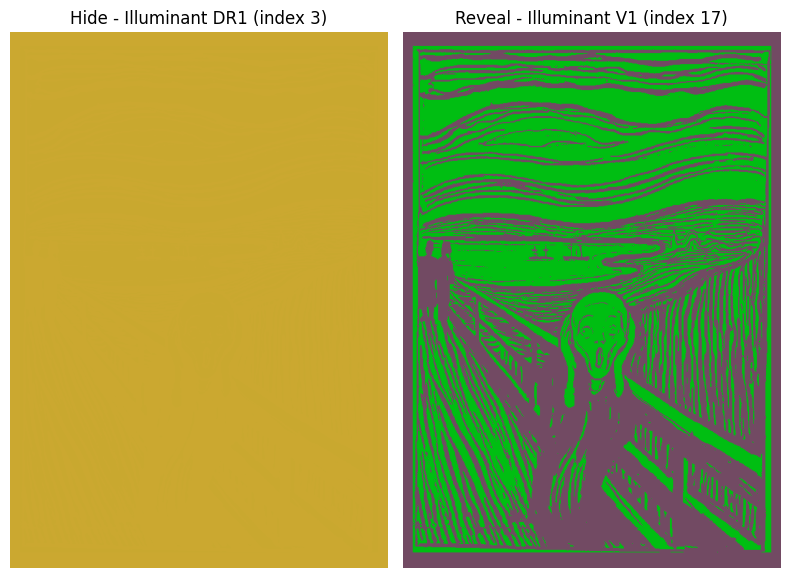

In [25]:
# Convert the Lab values to RGB
lab_bg_reveal = Lab_patches[best_r, best_i, :]
lab_msg_reveal = Lab_patches[best_r, best_j, :]
lab_bg_hide   = Lab_patches[best_h, best_i, :]
lab_msg_hide  = Lab_patches[best_h, best_j, :]

rgb_bg_reveal = lab2rgb(lab_bg_reveal.reshape(1,1,3))
rgb_msg_reveal = lab2rgb(lab_msg_reveal.reshape(1,1,3))
rgb_bg_hide   = lab2rgb(lab_bg_hide.reshape(1,1,3))
rgb_msg_hide  = lab2rgb(lab_msg_hide.reshape(1,1,3))

image_path = "images/munch.gif"

import matplotlib.pyplot as plt

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

img_hide = create_binarized_art_image(image_path, rgb_bg_hide, rgb_msg_hide)
img_reveal = create_binarized_art_image(image_path, rgb_bg_reveal, rgb_msg_reveal)

axes[0].imshow(img_hide)
axes[0].set_title("Hide - Illuminant {} (index {})".format(illuminant_names[best_h], best_h))
axes[0].axis("off")

axes[1].imshow(img_reveal)
axes[1].set_title("Reveal - Illuminant {} (index {})".format(illuminant_names[best_r], best_r))
axes[1].axis("off")

plt.tight_layout()
plt.show()